In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
import scipy.signal
import heapq
from sklearn import preprocessing

/Users/mclinwong/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")

print(f'Devices: {device}')

Devices: cpu


In [3]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
read_temp=scipy.io.loadmat(matpath + 'data2_snr.mat')
T_SBC_R=read_temp['T_SBC_R']
T_SBC=read_temp['T_SBC']
SNR=read_temp['SNR']
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1, 3)
[r2, K, I, S] = np.shape(S_est)
S_abs = np.zeros((r2, I*2, S))
for i in range(r2):
    for k in range(S):
        for j in range(I):
            S_abs[i, j, k] = S_est[i, 0, j, k]
            S_abs[i, I+j, k] = S_est[i, 1, j, k]    

S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est[:, :, 0])

#r2 = 1000, for the number of data
#K = 2, for the number of sources
#I = 120, for the number of DOAs
#S =31, for the number of SNRs

[r2,c,S]=np.shape(R_est)
[r2,I,S]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}, S: {S}')
print(f'S_est: {S_est.shape}, S_abs: {S_abs.shape}' 
      f'\nS_label: {S_label.shape}, S_label1: {S_label1.shape}'
      f'\nR_est: {R_est.shape}')


DOA = np.arange(I)-60
L = I

r2: 1000, I: 120, c: 56, S: 31
S_est: (1000, 2, 120, 31), S_abs: (1000, 240, 31)
S_label: (1000, 120, 31), S_label1: (1000, 120, 1, 31)
R_est: (1000, 56, 31)


In [4]:
class CNN_ReLu(nn.Module):
    def __init__(self):
        super(CNN_ReLu, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.cnn_1(x))
        x = self.relu(self.cnn_2(x))
        x = self.relu(self.cnn_3(x))
        x = self.relu(self.cnn_4(x))
        return x
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')

In [5]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super(CNN_tanh, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.cnn_1(x))
        x = self.tanh(self.cnn_2(x))
        x = self.tanh(self.cnn_3(x))
        x = self.tanh(self.cnn_4(x))
        return x
cnntanh = torch.load(pthpath + 'cnntanh.pth')

In [6]:
class CNN_sigmoid(nn.Module):
    def __init__(self):
        super(CNN_sigmoid, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.cnn_1(x))
        x = self.sigmoid(self.cnn_2(x))
        x = self.sigmoid(self.cnn_3(x))
        x = self.sigmoid(self.cnn_4(x))
        return x
cnnsigmoid = torch.load(pthpath + 'cnnsigmoid.pth')

In [7]:
class DNN_ReLU(nn.Module):
    def __init__(self):
        super(DNN_ReLU, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
dnnrelu = torch.load(pthpath + 'dnnrelu.pth') 

In [8]:
class DNN_Tanh(nn.Module):
    def __init__(self):
        super(DNN_Tanh, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x
dnntanh = torch.load(pthpath + 'dnntanh.pth')

In [9]:
class DNN_Sigmoid(nn.Module):
    def __init__(self):
        super(DNN_Sigmoid, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
dnnsigmoid = torch.load(pthpath + 'dnnsigmoid.pth')

In [10]:
def Test(model, inputx, k, flag):
    #flag==0 for CNN, flag==1 for DNN
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            if flag==0:
                x = torch.from_numpy(inputx[i,:,:,k]).float().to(device)
            if flag==1:
                x = torch.from_numpy(inputx[i,:,k]).float().to(device)
            x = x.to(device)
            y = model(x)
            y = y.cpu().numpy()
            #Turn the output into a 1D array
            y = np.squeeze(y)
            ls.append(y)
    predict = np.array(ls)
    return predict

In [11]:
test_cnn_low=np.zeros((r2,1))


def predict2doaarray(model, input, flag):
    predict = np.zeros((r2, I, S))
    for i in range(S):
        predict1 = Test(model, input, i, flag)
        
        predict[:, :, i] = predict1
    return predict

doa_dnntanharray = predict2doaarray(dnntanh, S_abs, 1)
doa_dnnreluarray = predict2doaarray(dnnrelu, S_abs, 1)
doa_dnnsigmoidarray = predict2doaarray(dnnsigmoid, S_abs, 1)
doa_dcntanharray = predict2doaarray(cnntanh, S_est, 0)
doa_dcnreluarray = predict2doaarray(cnnrelu, S_est, 0)
doa_dcnsigmoidarray = predict2doaarray(cnnsigmoid, S_est, 0)

In [12]:
def DOAarray2peak(predict, height = 0.1, nodetect = -200):
    #flag==0 for CNN, flag==1 for DNN
    peak = np.zeros((K, r2, S))
    for i in range(r2):
        for m in range(S):
            li = predict[i, :, m]
            peaks_st = np.zeros((K))
            peaks_st = peaks_st + nodetect
            peaks,_ = scipy.signal.find_peaks(li, height=height)
            maxamp = heapq.nlargest(K, li[peaks])
            rank = np.zeros(np.shape(maxamp)[0])
            for s in range(np.shape(maxamp)[0]):
                rank[s] = np.where(li==maxamp[s])[0].item()
            
            if len(peaks) == K:
                peaks_st = peaks
            elif len(peaks) == 0:
                peaks_st = peaks_st
            elif len(peaks) < K:
                for t in range(len(peaks)):
                    peaks_st[t] = peaks[t]
            elif len(peaks) > K:
                for j in range(K):
                    peaks_st[j] = rank[j]

            peak[:, i, m] = sorted(peaks_st, reverse=True)
        # if peaks_st[0] > peaks_st[1]:
        #     peak[:,i] = [peaks_st[0], peaks_st[1]]
        # else:
        #     peak[:,i] = [peaks_st[1], peaks_st[0]]
    return peak-60

doa_dnntanh = DOAarray2peak(doa_dnntanharray)
doa_dnnrelu = DOAarray2peak(doa_dnnreluarray)
doa_dnnsigmoid = DOAarray2peak(doa_dnnsigmoidarray)

doa_dcntanh = DOAarray2peak(doa_dcntanharray)
doa_dcnrelu = DOAarray2peak(doa_dcnreluarray)
doa_dcnsigmoid = DOAarray2peak(doa_dcnsigmoidarray)

In [13]:
#change the column
def switchcolumn(inarray):
    a = np.zeros((K, r2, S))
    a[0, :, :] = inarray[1, :, :]
    a[1, :, :] = inarray[0, :, :]
    return a

def caculate_rmse(predictDOApeek):
    predictDOApeek = switchcolumn(predictDOApeek)
    rmse_matrix_power = np.zeros((r2, 1))
    rmse = np.zeros((S, 1))
    for s in range(S):
        for r in range(r2):
            rmse_matrix_power[r] = np.mean(np.square(predictDOApeek[:, r, s] - DOA_train[:, r, s]))
        rmse[s] = np.sqrt(np.mean(rmse_matrix_power))
    return rmse

rmse_dnntanh = caculate_rmse(doa_dnntanh)
rmse_dnnrelu = caculate_rmse(doa_dnnrelu)
rmse_dnnsigmoid = caculate_rmse(doa_dnnsigmoid)

rmse_dcntanh = caculate_rmse(doa_dcntanh)
rmse_dcnrelu = caculate_rmse(doa_dcnrelu)
rmse_dcnsigmoid = caculate_rmse(doa_dcnsigmoid)

In [14]:
doa_sbl = DOAarray2peak(gamma)
rmse_sbl = caculate_rmse(doa_sbl)

doa_sblr = DOAarray2peak(gamma_R)
rmse_sblr = caculate_rmse(doa_sblr)

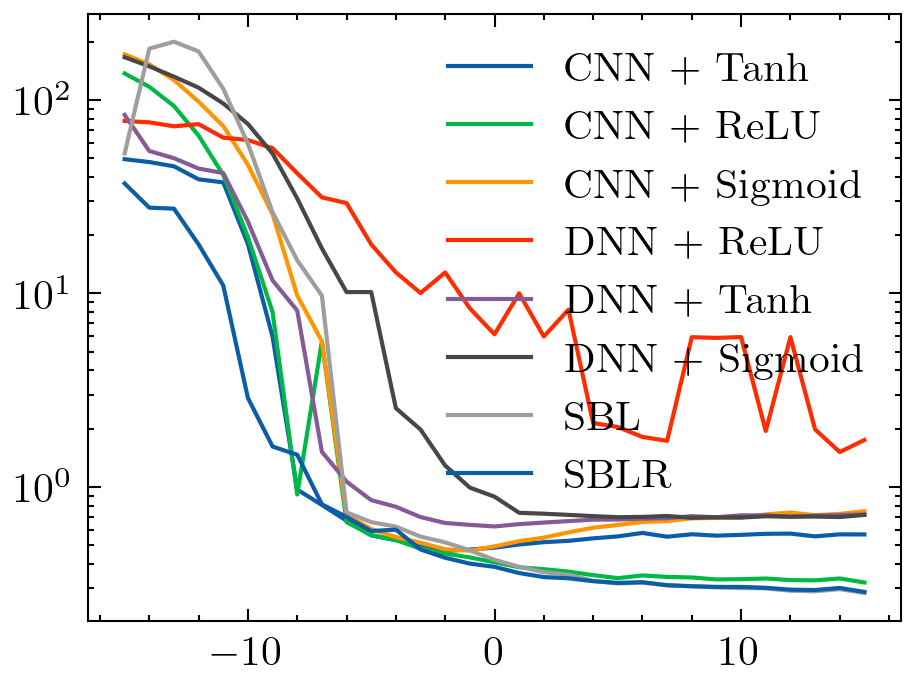

In [15]:
leftrange = -15
rightrange = 15
snr_list = range(leftrange,rightrange+1)
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    # plt.ylim([0.1,100])
    plt.semilogy(snr_list, rmse_dcntanh[leftrange+15:rightrange+16, :], label='CNN + Tanh')
    plt.semilogy(snr_list, rmse_dcnrelu[leftrange+15:rightrange+16, :], label='CNN + ReLU')
    plt.semilogy(snr_list, rmse_dcnsigmoid[leftrange+15:rightrange+16, :], label='CNN + Sigmoid')
    plt.semilogy(snr_list, rmse_dnnrelu[leftrange+15:rightrange+16, :], label='DNN + ReLU')
    plt.semilogy(snr_list, rmse_dnntanh[leftrange+15:rightrange+16, :], label='DNN + Tanh')
    plt.semilogy(snr_list, rmse_dnnsigmoid[leftrange+15:rightrange+16, :], label='DNN + Sigmoid')
    plt.semilogy(snr_list, rmse_sbl[leftrange+15:rightrange+16, :], label='SBL')
    plt.semilogy(snr_list, rmse_sblr[leftrange+15:rightrange+16, :], label='SBLR')
    plt.savefig(figurepath + 'SNR_VS_RMSE/Total Rmse.pdf')
    plt.legend()
    plt.show()